# Overview

This notebook provides support for an article at Medium.com.

Initial concepts over at [ComparisonGroupScratchSpace.ipynb](ComparisonGroupScratchSpace).

In [1]:
import pandas as pd
import numpy as np

from math import sqrt
from scipy.spatial import distance
from scipy.stats import zscore

from pandas_profiling import ProfileReport
import seaborn as sns

# Get & Prepare Data

In [2]:
location = r'~/documents/ipeds_data/'
dir_info = pd.read_stata(location + 'IPEDSDirInfo02to18.dta')
inst_chs = pd.read_stata(location + 'IPEDSInstChar02to18.dta')

In [3]:
dir_info_17 = dir_info[dir_info['isYr'] == 2017].copy()
inst_chs_17 = inst_chs[inst_chs['isYr'] == 2017].copy()

del dir_info_17['isYr']
del inst_chs_17['isYr']

In [4]:
df = pd.merge(dir_info_17, inst_chs_17, on='unitid')

In [5]:
# Keep a subset of variables only.
#  unitid   : Unique identificaiotn number.
#  instnm   : Institution name.
#  stabbr   : Institution state abbreviation.
#  sector   : Sector (public, private, 2yr, 4yr, etc.)
#  iclevel  : Two-years, four-yeasr, etc.
#  control  : Public or private institution status.
#  locale   : Urbanicity index.
#  instcat  : Degree-granting category.
#  c18basic : Carnegie classification.
#  instsize : Categorical institution size.
#  longitud : Geographic longidue location.
#  latitude : Geographic latitude location.
#  roomcap  : Residence hall room capacity.
#  roomamt  : Residence hall room fees.
#  boardamt : Dining hall fees.
#  applfeeu : Application fees.
#  applcn   : Count of undergraduate applications.
#  admssn   : Count of undergraduate admissions.
#  enrlft   : Count of full-time enrollment.
#  enrlt    : Count of enrollment.

df = df[['unitid','instnm','stabbr','sector','iclevel',
         'control','locale','instcat','c15basic','instsize',
         'longitud','latitude','roomcap','roomamt','boardamt',
         'applfeeu','applcn','admssn','enrlft','enrlt']]

df['accept'] = df['admssn'] / df['applcn']
                                 
df.set_index('unitid', inplace=True)

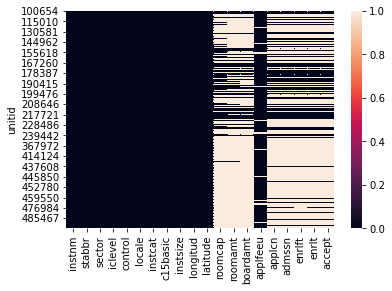

In [6]:
sns.heatmap(df.isna())

In [7]:
# Limit the analysis to public & private 4 year institutions
df = df[(df['sector'] == 'Public, 4-year or above') | \
        (df['sector'] == 'Private not-for-profit, 4-year or above')]
# Limit the analysis to schools with a residence hall capacity.
df = df[df['roomcap'].fillna(-9999) != -9999]
# Limit the analysis to schools that report application data.
df = df[df['applcn'].fillna(-9999) != -9999]

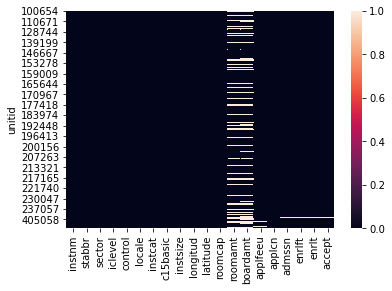

In [8]:
sns.heatmap(df.isna())

In [9]:
df[['roomamt','boardamt']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
roomamt,1238.0,6082.14378,2171.780094,0.0,4600.0,5900.0,7354.5,16675.0
boardamt,1170.0,4597.68547,1193.423839,0.0,3830.0,4581.5,5340.0,8965.0


In [10]:
# Replace missing room and board amt with zero (free??)
df['roomamt'].fillna(0, inplace=True)
df['boardamt'].fillna(0, inplace=True)
df['applfeeu'].fillna(0, inplace=True)

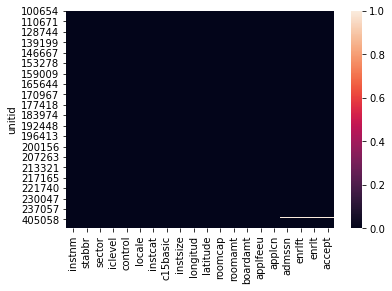

In [11]:
sns.heatmap(df.isna())

In [12]:
df[df['admssn'].fillna(-9999) == -9999][['instnm','applfeeu','admssn',
                                         'enrlft','enrlt','accept']]

,instnm,applfeeu,admssn,enrlft,enrlt,accept
unitid,,,,,,
142957,American Islamic College,25.0,NaN,NaN,NaN,NaN
245777,Bais Medrash Elyon,0.0,NaN,NaN,NaN,NaN
441609,Yeshiva Shaarei Torah of Rockland,100.0,NaN,NaN,NaN,NaN


In [13]:
# Drop these three observations.
df.dropna(inplace=True)

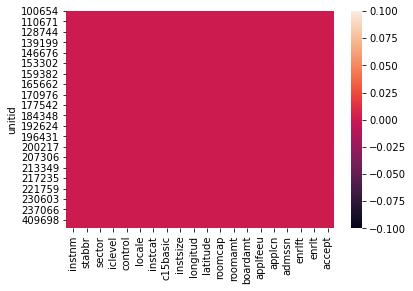

In [14]:
sns.heatmap(df.isna())

In [15]:
profile = ProfileReport(df, title="Pandas Profiling Report")

In [16]:
profile.to_file("ipeds_data_sample_2017_report.html")

Summarize dataset:   0%|          | 0/34 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Define Functions

In [17]:
def jaccard(data, ref, cols, verbose=False):
    '''Calculates Jarcard index for all observations
    relative to the referenced observation. Returns a list
    of Jaccardian distances.
    
    data = A dataframe.
    ref  = A reference observation. Specify by the axis 0 index.
    cols = A set of comparison columns.'''

    try:
        ref_observation = data[cols].iloc[ref]
    except IndexError:
        ref_observation = data[cols].loc[ref]
        ref = df.index.get_loc(ref)
    
    distances = []
    length = len(cols) 
        
    for row in range(len(data)):
        comp_observation = data[cols].iloc[row]
        matches = sum([1 if x == y else 0 for x, y in zip(ref_observation,
                                                          comp_observation)])
        distances.append(1 - (matches / length))
    
    if verbose:
        print('Returning {} distances.'.format(len(distances)))
        print('Minimum distance = 0 : {}'.format(min(distances) == 0))
        print('Maximum distance = {}'.format(max(distances)))
        print('Mean distance = {}'.format(sum(distances) / len(distances)))
        
    return(distances)

# Goal: Count the number of matching dimensions among two observations
def hamming(data, ref, cols):
    '''Calculates Hamming distance for all observations
    relative to the referenced observation. Returns a list
    of hamming distances.
    
    data = A dataframe.
    ref  = A reference observation. Specify by the axis 0 index.
    cols = A set of comparison columns.'''

    if type(ref) == int:
        ref = ref
    if type(ref) == str:
        ref = df.index.get_loc(ref)

    distances = []
    ref_observation = data[cols].iloc[ref]
    for row in range(len(data)):
        comp_observation = data[cols].iloc[row]
        matches = sum([1 if x == y else 0 for x, y in zip(comp_observation,
                                                          ref_observation)])
        distances.append(matches)
    return(distances)

def euclidian(data, ref, cols, verbose=False):
    '''Calculates Euclidian distance for all observations
    relative to the referenced observation. Returns a list
    of euclidian distances.
    
    data = A dataframe.
    ref  = A reference observation. Specify by the axis 0 index.
    cols = A set of comparison columns.'''
        
    try:
        ref_observation = data[cols].apply(zscore).iloc[ref]
    except IndexError:
        ref_observation = data[cols].apply(zscore).loc[ref] 
        ref = df.index.get_loc(ref)
    
    distances = []
    for row in range(len(data)):
        comp_observation = data[cols].apply(zscore).iloc[row]
        dist = distance.euclidean(ref_observation, comp_observation)
        distances.append(dist)
        
    if verbose:
        print('Returning {} distances.'.format(len(distances)))
        print('Minimum distance = 0 : {}'.format(min(distances) == 0))
        print('Maximum distance = {}'.format(max(distances)))
        print('Mean distance = {}'.format(sum(distances) / len(distances)))
    
    return(distances)

# Case Sudies

## University of Wisconsin-Madison

### Euclidian

In [18]:
# Review Madison's profile based on this data.
df.loc[240444]

instnm                        University of Wisconsin-Madison
stabbr                                                     WI
sector                                Public, 4-year or above
iclevel                                    Four or more years
control                                                Public
locale                                            City: Large
instcat     Degree-granting, primarily baccalaureate or above
c15basic     Doctoral Universities: Highest Research Activity
instsize                                     20,000 and above
longitud                                             -89.4041
latitude                                              43.0754
roomcap                                                  8644
roomamt                                                  6225
boardamt                                                 3125
applfeeu                                                   60
applcn                                                  35596
admssn  

In [19]:
continous_cols = ['longitud','latitude','roomcap','roomamt',
                  'applfeeu','accept','enrlft']
df['WI_euclidian'] = euclidian(data=df, ref=240444, 
                               cols=continous_cols,
                               verbose=True)

Returning 1541 distances.
Minimum distance = 0 : True
Maximum distance = 17.239787279528322
Mean distance = 5.844234011622871


In [20]:
# Verify that Wisconsin is distance zero from itself
print(df.loc[240444]['WI_euclidian'] == 0)
print(df.loc[240444]['WI_euclidian'])

True
0.0


In [21]:
df.sort_values(by='WI_euclidian', inplace=True)
df[['instnm','stabbr'] + continous_cols + ['WI_euclidian']].head(n=10)

,instnm,stabbr,longitud,latitude,roomcap,roomamt,applfeeu,accept,enrlft,WI_euclidian
unitid,,,,,,,,,,
240444,University of Wisconsin-Madison,WI,-89.404099,43.075409,8644.0,6225.0,60.0,0.538066,6597.0,0.000000
174066,University of Minnesota-Twin Cities,MN,-93.235466,44.972851,7294.0,5586.0,55.0,0.496033,6183.0,0.870541
233921,Virginia Polytechnic Institute and State Unive...,VA,-80.423676,37.229012,9459.0,5212.0,60.0,0.700580,6832.0,1.616283
181464,University of Nebraska-Lincoln,NE,-96.700508,40.817596,7200.0,6594.0,45.0,0.643808,4883.0,1.748170
201885,University of Cincinnati-Main Campus,OH,-84.514282,39.131161,6690.0,6624.0,50.0,0.764924,5358.0,1.914102
216339,Temple University,PA,-75.156860,39.980545,6003.0,7752.0,55.0,0.566695,5141.0,1.988534
139959,University of Georgia,GA,-83.374039,33.956261,9727.0,6104.0,70.0,0.540120,5809.0,2.075897
130943,University of Delaware,DE,-75.752823,39.679577,7274.0,7462.0,75.0,0.628853,4649.0,2.088865
243780,Purdue University-Main Campus,IN,-86.914436,40.428207,12979.0,4860.0,60.0,0.574685,7697.0,2.157024


### Jacardian

In [22]:
# Review Madison's profile based on this data.
df.loc[240444]

instnm                            University of Wisconsin-Madison
stabbr                                                         WI
sector                                    Public, 4-year or above
iclevel                                        Four or more years
control                                                    Public
locale                                                City: Large
instcat         Degree-granting, primarily baccalaureate or above
c15basic         Doctoral Universities: Highest Research Activity
instsize                                         20,000 and above
longitud                                                 -89.4041
latitude                                                  43.0754
roomcap                                                      8644
roomamt                                                      6225
boardamt                                                     3125
applfeeu                                                       60
applcn    

In [23]:
# Designate selective as those above median
df['isSelect'] = df['accept'] > df['accept'].median()
# Designate large as those enrolling above median
df['isBig'] = df['enrlft'] > df['enrlft'].median()

In [24]:
cat_cols = ['stabbr','sector','locale','c15basic',
            'isSelect','isBig']
df['WI_jacardian'] = jaccard(data=df, ref=240444, 
                             cols=cat_cols,
                             verbose=True)

Returning 1541 distances.
Minimum distance = 0 : True
Maximum distance = 1.0
Mean distance = 0.7253947653039189


In [25]:
df.sort_values(by=['WI_jacardian','WI_euclidian'], inplace=True)
df[['instnm','stabbr'] + cat_cols + \
   ['WI_euclidian','WI_jacardian']].head(n=10)

,instnm,stabbr,stabbr,sector,locale,c15basic,isSelect,isBig,WI_euclidian,WI_jacardian
unitid,,,,,,,,,,
240444,University of Wisconsin-Madison,WI,WI,"Public, 4-year or above",City: Large,Doctoral Universities: Highest Research Activity,False,True,0.000000,0.000000
174066,University of Minnesota-Twin Cities,MN,MN,"Public, 4-year or above",City: Large,Doctoral Universities: Highest Research Activity,False,True,0.870541,0.166667
181464,University of Nebraska-Lincoln,NE,NE,"Public, 4-year or above",City: Large,Doctoral Universities: Highest Research Activity,False,True,1.748170,0.166667
216339,Temple University,PA,PA,"Public, 4-year or above",City: Large,Doctoral Universities: Highest Research Activity,False,True,1.988534,0.166667
215293,University of Pittsburgh-Pittsburgh Campus,PA,PA,"Public, 4-year or above",City: Large,Doctoral Universities: Highest Research Activity,False,True,2.215002,0.166667
199193,North Carolina State University at Raleigh,NC,NC,"Public, 4-year or above",City: Large,Doctoral Universities: Highest Research Activity,False,True,2.365929,0.166667
236948,University of Washington-Seattle Campus,WA,WA,"Public, 4-year or above",City: Large,Doctoral Universities: Highest Research Activity,False,True,3.084111,0.166667
225511,University of Houston,TX,TX,"Public, 4-year or above",City: Large,Doctoral Universities: Highest Research Activity,False,True,3.161267,0.166667
240453,University of Wisconsin-Milwaukee,WI,WI,"Public, 4-year or above",City: Large,Doctoral Universities: Highest Research Activity,True,True,3.306935,0.166667


## University of North Carolina Charlotte

In [26]:
df.loc[199139]

instnm                  University of North Carolina at Charlotte
stabbr                                                         NC
sector                                    Public, 4-year or above
iclevel                                        Four or more years
control                                                    Public
locale                                                City: Large
instcat         Degree-granting, primarily baccalaureate or above
c15basic          Doctoral Universities: Higher Research Activity
instsize                                         20,000 and above
longitud                                                 -80.7309
latitude                                                   35.306
roomcap                                                      6127
roomamt                                                      6150
boardamt                                                     4630
applfeeu                                                       60
applcn    

In [27]:
continous_cols = ['longitud','latitude','roomcap','roomamt',
                  'applfeeu','accept','enrlft']
df['CLT_euclidian'] = euclidian(data=df, ref=199139, 
                                cols=continous_cols,
                                verbose=True)

Returning 1541 distances.
Minimum distance = 0 : True
Maximum distance = 15.42256115155732
Mean distance = 3.811735872261737


In [28]:
# Verify that Wisconsin is distance zero from itself
print(df.loc[199139]['CLT_euclidian'] == 0)
print(df.loc[199139]['CLT_euclidian'])

True
0.0


In [29]:
df.sort_values(by='CLT_euclidian', inplace=True)
df[['instnm','stabbr'] + continous_cols + ['CLT_euclidian']].head(n=10)

,instnm,stabbr,longitud,latitude,roomcap,roomamt,applfeeu,accept,enrlft,CLT_euclidian
unitid,,,,,,,,,,
199139,University of North Carolina at Charlotte,NC,-80.730919,35.306023,6127.0,6150.0,60.0,0.658361,3355.0,0.000000
197869,Appalachian State University,NC,-81.680580,36.215534,5679.0,4339.0,65.0,0.700050,3302.0,0.703402
199148,University of North Carolina at Greensboro,NC,-79.809418,36.068237,5325.0,6599.0,65.0,0.780379,2768.0,0.862303
217882,Clemson University,SC,-82.835114,34.679382,6448.0,5732.0,70.0,0.471763,3649.0,1.040937
176080,Mississippi State University,MS,-88.790138,33.454853,5223.0,5969.0,40.0,0.623989,3428.0,1.090204
232186,George Mason University,VA,-77.307426,38.829975,6518.0,6700.0,70.0,0.813247,3442.0,1.156330
198464,East Carolina University,NC,-77.368294,35.607185,5796.0,5366.0,75.0,0.790227,4312.0,1.178801
218724,Coastal Carolina University,SC,-79.011765,33.794994,4685.0,5440.0,45.0,0.611916,2381.0,1.208010
234030,Virginia Commonwealth University,VA,-77.453598,37.547630,5158.0,7209.0,65.0,0.838995,4117.0,1.289301


In [30]:
continous_cols = ['roomcap','roomamt',
                  'applfeeu','accept','enrlft']
df['CLT_euclidian'] = euclidian(data=df, ref=199139, 
                                cols=continous_cols,
                                verbose=True)

Returning 1541 distances.
Minimum distance = 0 : True
Maximum distance = 6.693730791049066
Mean distance = 3.45765266475053


In [31]:
df.sort_values(by='CLT_euclidian', inplace=True)
df[['instnm','stabbr'] + continous_cols + ['CLT_euclidian']].head(n=10)

,instnm,stabbr,roomcap,roomamt,applfeeu,accept,enrlft,CLT_euclidian
unitid,,,,,,,,
199139,University of North Carolina at Charlotte,NC,6127.0,6150.0,60.0,0.658361,3355.0,0.000000
217484,University of Rhode Island,RI,6229.0,7952.0,65.0,0.700580,3163.0,0.662338
197869,Appalachian State University,NC,5679.0,4339.0,65.0,0.700050,3302.0,0.675928
201441,Bowling Green State University-Main Campus,OH,6203.0,6180.0,45.0,0.732037,3326.0,0.685270
183044,University of New Hampshire-Main Campus,NH,6682.0,7024.0,65.0,0.765051,3015.0,0.709694
228769,The University of Texas at Arlington,TX,7520.0,5116.0,60.0,0.712235,3163.0,0.744487
228787,The University of Texas at Dallas,TX,5543.0,7224.0,50.0,0.760326,3085.0,0.785524
230764,University of Utah,UT,5412.0,5118.0,45.0,0.661518,3853.0,0.826806
231174,University of Vermont,VT,5717.0,7900.0,55.0,0.671957,2622.0,0.830578
